---

Objective: Membangun model prediksi untuk mengidentifikasi individu yang berisiko terkena penyakit jantung berdasarkan data medis, sehingga pasien berisiko tinggi dapat menerima langkah pencegahan dan perawatan awal, sementara pasien berisiko rendah mendapatkan panduan untuk menjaga kesehatan jantung mereka.

---

# Latar Belakang

Penyakit jantung merupakan salah satu penyakit mematikan di Indonesia maupun di Dunia. Menurut data Kementerian Kesehatan, penyakit ini menyumbang angka kematian yang cukup tinggi, terutama karena sering terlambat terdeteksi. Melalui proyek ini, model prediksi akan dibuat untuk mengidentifikasi siapa saja yang memiliki risiko terkena gagal jantung berdasarkan data medis yang tersedia.

- Bagi pasien yang terprediksi memiliki risiko tinggi, akan diberikan informasi lebih lanjut tentang langkah pencegahan dan penanganan awal.
- Bagi mereka yang berisiko rendah, akan tetap disediakan panduan untuk menjaga kesehatan jantung dan menghindari faktor risiko.
- Proyek ini berfokus pada memprediksi risiko gagal jantung untuk membantu tindakan pencegahan yang lebih dini.


# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import warnings
warnings.filterwarnings("ignore")

# Preprocessing dan Feature Engineering
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from feature_engine.outliers import Winsorizer
from imblearn.over_sampling import SMOTE

# feature selection
from scipy.stats import kendalltau
from scipy.stats import chi2_contingency

# Pipeline untuk menggabungkan preprocessing dan model
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
# Evaluation
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


# Data Loading

## Data Dictionary

| **Kolom**         | **Deskripsi**                                                                                                                                                     |
|-------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Age**           | Umur pasien [tahun]                                                                                                                                               |
| **Sex**           | Jenis kelamin pasien [M: Laki-laki, F: Perempuan]                                                                                                                  |
| **ChestPainType**  | Jenis nyeri dada [TA: Angina Tipikal, ATA: Angina Atypikal, NAP: Nyeri Non-Angina, ASY: Asimptomatik]                                                              |
| **RestingBP**     | Tekanan darah istirahat [mm Hg]                                                                                                                                   |
| **Cholesterol**    | Kolesterol serum [mm/dl]                                                                                                                                          |
| **FastingBS**     | Gula darah puasa [1: jika FastingBS > 120 mg/dl, 0: sebaliknya]                                                                                                    |
| **RestingECG**    | Hasil elektrokardiogram istirahat [Normal: Normal, ST: memiliki abnormalitas gelombang ST-T (inversi gelombang T dan/atau elevasi atau depresi ST > 0.05 mV), LVH: menunjukkan hipertrofi ventrikel kiri yang mungkin atau pasti berdasarkan kriteria Estes] |
| **MaxHR**         | Denyut jantung maksimum yang dicapai [Nilai numerik antara 60 dan 202]                                                                                             |
| **ExerciseAngina**| Angina akibat olahraga [Y: Ya, N: Tidak]                                                                                                                           |
| **Oldpeak**       | Oldpeak = ST [Nilai numerik yang diukur dalam depresi]                                                                                                             |
| **ST_Slope**      | Kemiringan segmen ST saat puncak latihan [Up: menaik, Flat: datar, Down: menurun]                                                                                  |
| **HeartDisease**  | Kelas keluaran [1: penyakit jantung, 0: Normal] 

In [2]:
# Load Dataset
df = pd.read_csv('heart.csv')

## Displaying the Dataset

In [3]:
# Menampilkan data
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


## Check Data Info

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Dataset terdiri 918 data dengan 12 kolom.

## Check Duplicated Data

In [5]:
# Check Duplicated Data
df.duplicated().sum()

0

# Exploratory Data Analysis (EDA)

## Check Missing Values

In [6]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

tidak ada kolom yang missing

## Split Categorical and Numerical Data

In [7]:
df['FastingBS'].value_counts()

FastingBS
0    704
1    214
Name: count, dtype: int64

In [8]:
cat_col= ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
num_col= ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
cat_num_col= ['FastingBS']
print(cat_col)
print(num_col)
print(cat_num_col)

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
['FastingBS']


## Check Distribution and Skewness

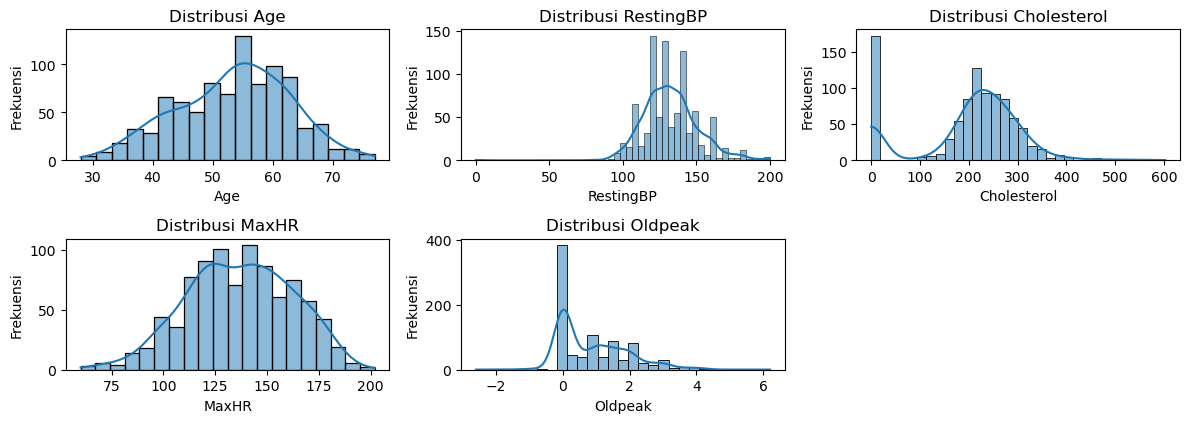

In [9]:
# Visualisasi Distribusi seluruh data numerik dengan cek skewness dataset 1
plt.figure(figsize=(12, 6))
for i, col in enumerate(num_col):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribusi {col}'),
    plt.xlabel(col)
    plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()


- Distribusi Kolom Age, MaxHR, Oldpeak cenderung normal
- Distribusi RestingBP, Kolesterol, FastingBS cenderung miring ke kanan

In [10]:
# Cek skewness data seluruh data numerik
for col in num_col:
  skewness = df[col].skew()
  print(f'Skewness of {col}: {skewness:.3f}')

Skewness of Age: -0.196
Skewness of RestingBP: 0.180
Skewness of Cholesterol: -0.610
Skewness of MaxHR: -0.144
Skewness of Oldpeak: 1.023


## Check Correlation Matrix

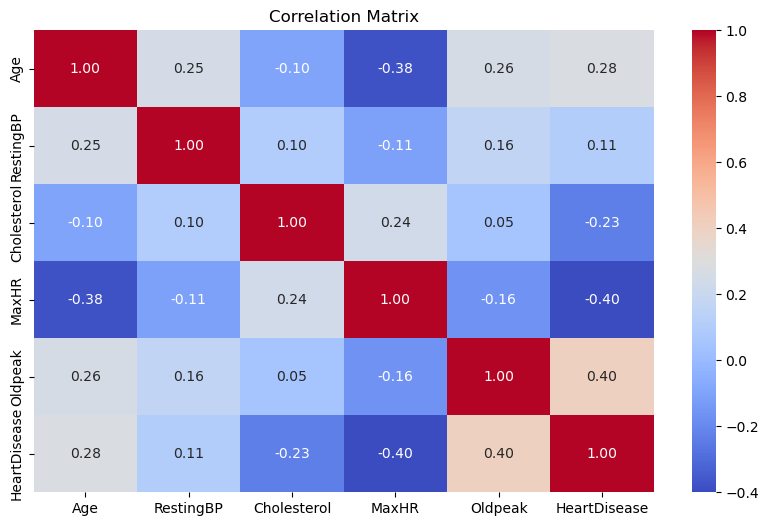

In [11]:
# Korelasi antar fitur numerikal
corr_matrix = df[num_col + ['HeartDisease']].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Hubungan Positif yang Kuat:
- Usia (Age) dengan (Heart Disease): Semakin tua seseorang, semakin tinggi risiko terkena penyakit jantung.
- Oldpeak dengan (Heart Disease): Oldpeak, yang mungkin terkait dengan stres pada jantung, memiliki korelasi positif yang kuat dengan penyakit jantung.

Hubungan Positif yang Lemah:
- RestingBP  dengan Heart Disease: Meskipun ada korelasi positif, hubungannya tidak terlalu kuat.
- Kolesterol dengan Heart Disease: Hubungan antara kolesterol dan penyakit jantung juga positif tetapi lemah.

Hubungan Negatif:
- MaxHR dengan Heart Disease: Semakin tinggi denyut jantung maksimum, semakin rendah risiko penyakit jantung.

## Distribution Column `HeartDisease`

In [12]:
df['HeartDisease'].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

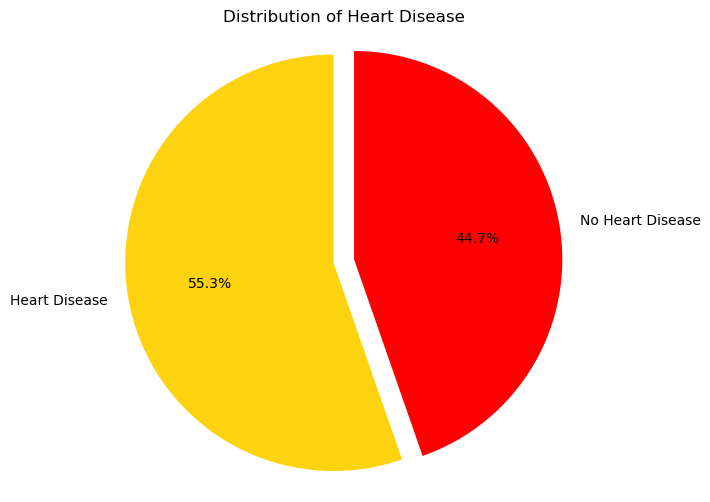

In [13]:
# Menghitung jumlah orang yang memiliki dan tidak memiliki HeartDisease
heart_disease_counts = df['HeartDisease'].value_counts()

# Label untuk pie chart
labels = ['Heart Disease','No Heart Disease']

# Membuat pie chart
plt.figure(figsize=(6, 6))
plt.pie(heart_disease_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#FDD20E', 'r'], explode=[0, 0.1])
plt.title('Distribution of Heart Disease')
plt.axis('equal')  # Agar pie chart menjadi lingkaran sempurna
plt.show()

Sekitar 44.7% dari populasi dalam dataset tidak memiliki penyakit jantung, sedangkan 55.3% yang memiliki penyakit jantung.

## Heart Disease Distribution by Gender

In [14]:
df.groupby('Sex')['HeartDisease'].value_counts()

Sex  HeartDisease
F    0               143
     1                50
M    1               458
     0               267
Name: count, dtype: int64

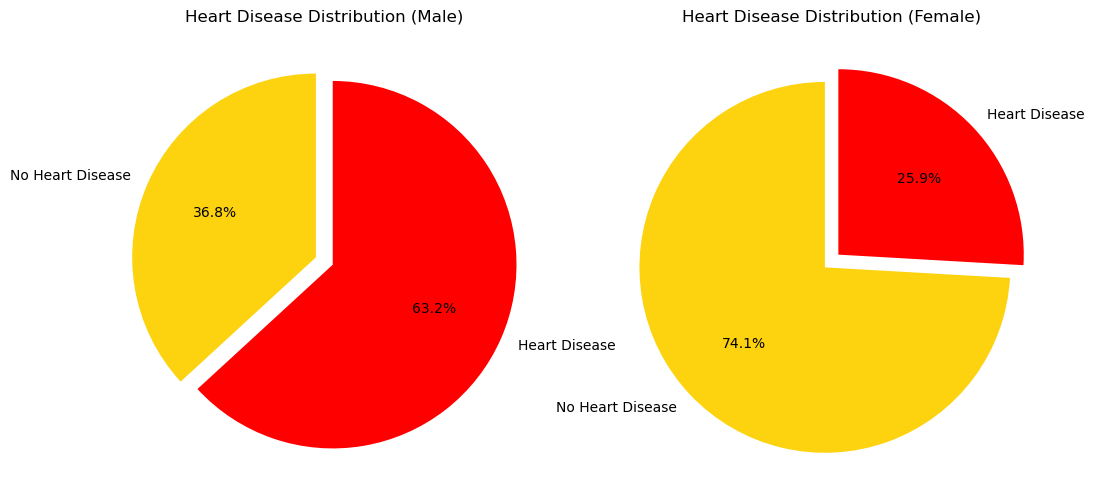

In [15]:
# Mengelompokkan data berdasarkan Sex dan HeartDisease
grouped_sex_hd = df.groupby(['Sex', 'HeartDisease']).size().unstack()

# Membuat pie chart untuk setiap jenis kelamin
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart untuk Male
axes[0].pie(grouped_sex_hd.loc['M'], labels=['No Heart Disease', 'Heart Disease'], autopct='%1.1f%%', startangle=90, colors=['#FDD20E', 'red'], explode=[0, 0.1])
axes[0].set_title('Heart Disease Distribution (Male)')
axes[0].axis('equal')

# Pie chart untuk Female
axes[1].pie(grouped_sex_hd.loc['F'], labels=['No Heart Disease', 'Heart Disease'], autopct='%1.1f%%', startangle=90, colors=['#FDD20E', 'red'], explode=[0, 0.1])
axes[1].set_title('Heart Disease Distribution (Female)')
axes[1].axis('equal')

# Menampilkan chart
plt.show()

- Persentase pria yang memiliki penyakit jantung (63.2%) jauh lebih tinggi dibandingkan wanita (25.9%). Ini menunjukkan bahwa pria memiliki risiko lebih besar terkena penyakit jantung dibandingkan wanita.
- Sebaliknya, persentase wanita yang tidak memiliki penyakit jantung (74.1%) jauh lebih tinggi dibandingkan pria (36.8%). Ini mengindikasikan bahwa secara umum, wanita  memiliki kondisi jantung yang lebih sehat.

## Distribution of Heart Disease by Age

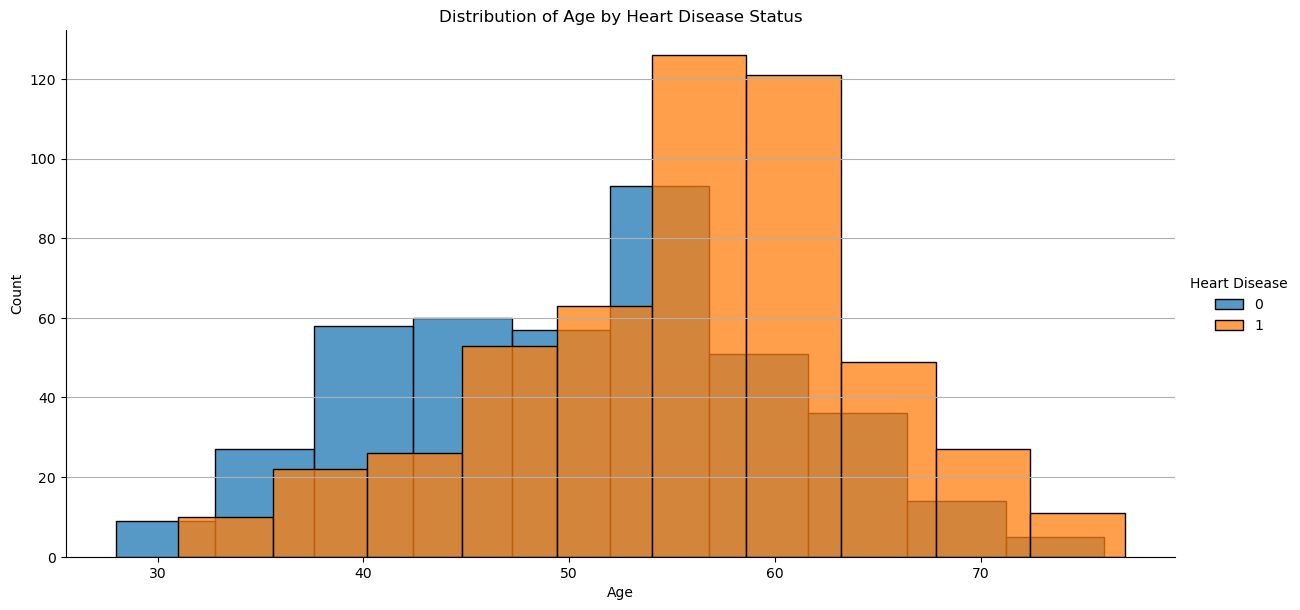

In [16]:
g = sns.FacetGrid(df, hue='HeartDisease', height=6, aspect=2)
g.map(sns.histplot, 'Age', bins=10, kde=False, stat='count')
g.add_legend(title='Heart Disease')
plt.title('Distribution of Age by Heart Disease Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(axis='y')

# Show the plot
plt.show()

Insight:
- Semakin tua usia seseorang, semakin tinggi kemungkinan mereka terkena penyakit jantung. Ini ditunjukkan oleh peningkatan jumlah kasus penyakit jantung pada kelompok usia yang lebih tua.
- Terdapat perbedaan yang cukup signifikan antara kelompok usia yang lebih muda dan lebih tua dalam hal jumlah penyakit jantung. Kelompok usia di atas 50 tahun memiliki proporsi kasus penyakit jantung yang jauh lebih tinggi dibandingkan kelompok usia di bawah 50 tahun.

## Distribution of Heart Disease by ChestPainType

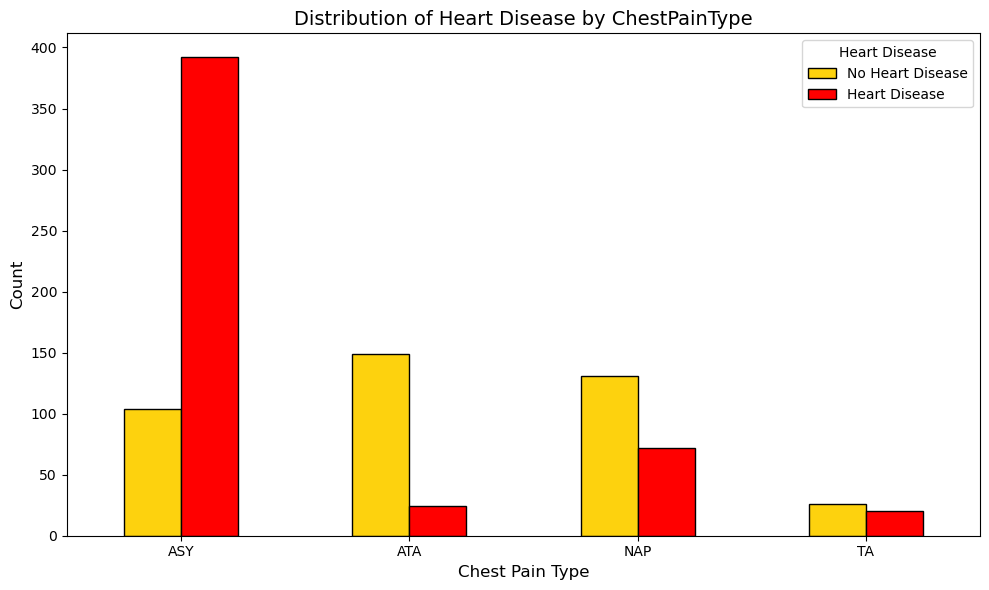

In [17]:
# Menghitung jumlah data berdasarkan ChestPainType dan HeartDisease
chest_pain_counts = df.groupby(['ChestPainType', 'HeartDisease']).size().unstack()

# Membuat bar chart
chest_pain_counts.plot(kind='bar', figsize=(10,6), color=['#FDD20E', 'red'], edgecolor='black')

# Menambahkan label dan judul
plt.title('Distribution of Heart Disease by ChestPainType', fontsize=14)
plt.xlabel('Chest Pain Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)

# Menambahkan legenda
plt.legend(['No Heart Disease', 'Heart Disease'], title="Heart Disease", loc="upper right")

# Menampilkan plot
plt.tight_layout()
plt.show()

- Nyeri Dada ASY: Nyeri dada tipe ASY memiliki jumlah kasus penyakit jantung yang paling tinggi, diikuti oleh nyeri dada NAP.
- Nyeri Dada ATA dan TA: Nyeri dada tipe ATA dan TA memiliki jumlah kasus penyakit jantung yang lebih rendah dibandingkan ASY dan ATA.
- Dapat disimpulkan bahwa Nyeri dada tipe ASY dan NAP memiliki hubungan yang lebih kuat dengan penyakit jantung dibandingkan ATA dan TA.

**Kesimpulan EDA:**
- Terdapat korelasi positif yang kuat antara 'Age' dan 'HeartDisease', menunjukkan bahwa risiko penyakit jantung meningkat seiring bertambahnya usia.
'Oldpeak' juga memiliki korelasi positif yang kuat dengan 'HeartDisease', mungkin menandakan pentingnya stres jantung. Sebaliknya, 'MaxHR' menunjukkan korelasi negatif, mengindikasikan bahwa denyut jantung maksimum yang lebih tinggi dapat mengurangi risiko penyakit jantung.

- Dalam dataset, sekitar 44.7% populasi terdiagnosis dengan penyakit jantung, sedangkan 55.3% tidak.
Data menunjukkan bahwa pria memiliki prevalensi penyakit jantung yang lebih tinggi (63.2%) dibandingkan wanita (25.9%), sedangkan wanita memiliki persentase lebih tinggi dalam tidak terdiagnosis penyakit jantung.

- Tipe nyeri dada 'ASY' dan 'NAP' menunjukkan hubungan yang lebih kuat dengan penyakit jantung dibandingkan dengan 'ATA' dan 'TA'.
- Terdapat tren yang jelas bahwa seiring bertambahnya usia, jumlah kasus penyakit jantung meningkat, terutama pada kelompok usia yang lebih tua.

**Rekomendasi:**
- Fokus pada kelompok usia lebih tua untuk program pencegahan dan skrining penyakit jantung.
- Perhatikan tipe nyeri dada yang berhubungan dengan risiko tinggi penyakit jantung untuk diagnosis yang lebih akurat.
- Pertimbangkan faktor gender dalam perencanaan intervensi kesehatan untuk menargetkan populasi yang paling berisiko.

# Feature Engineering

In [18]:
#split fitur dan target
X= df.drop('HeartDisease', axis=1) #fitur
y= df['HeartDisease'] #target

In [19]:
#pisahkan menjadi train dan test
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.3,
                                                  random_state=42
                                                   )

In [20]:
# Cek jumlah baris dan kolom
print(X_train.shape)
print(X_test.shape)

(642, 11)
(276, 11)


## Check And Handling Outliers

In [21]:
# Cek Skewness
for col in num_col:
  skewness = X_train[col].skew()
  print(f'Skewness of {col}: {skewness:.3f}')

Skewness of Age: -0.162
Skewness of RestingBP: 0.049
Skewness of Cholesterol: -0.738
Skewness of MaxHR: -0.169
Skewness of Oldpeak: 1.045


In [22]:
# Split Skew yang normal dan high
skewness = X_train[num_col].skew()
highly_skewed_col = list(skewness[abs(skewness) > 1].index)
normal_skewed_col = list(skewness[abs(skewness) <= 1].index)

highly_skewed_col, normal_skewed_col

(['Oldpeak'], ['Age', 'RestingBP', 'Cholesterol', 'MaxHR'])

In [23]:
def calculate_boundaries_and_outliers(df, columns, threshold=3):
    """
    Fungsi ini dibuat untuk menghitung upper boundary, lower boundary, dan persentase outlier untuk kolom yang distribusi datanya normal
    """
    results = {
        'Lower Boundary': [],
        'Upper Boundary': [],
        'Outlier Percentage': []
    }

    for column in columns:
        if column in df.columns:
            # Hitung z-score
            z_scores = (df[column] - df[column].mean()) / df[column].std()
            
            # Hitung lower dan upper boundary
            lower_boundary = df[column].mean() - threshold * df[column].std()
            upper_boundary = df[column].mean() + threshold * df[column].std()
            
            # Hitung persentase outlier
            outliers = ((z_scores < -threshold) | (z_scores > threshold)).sum()
            outlier_percentage = (outliers / len(df[column])) * 100
            
            # Simpan hasil
            results['Lower Boundary'].append(lower_boundary)
            results['Upper Boundary'].append(upper_boundary)
            results['Outlier Percentage'].append(outlier_percentage)
        else:
            # Jika kolom tidak ada, tambahkan None
            results['Lower Boundary'].append(None)
            results['Upper Boundary'].append(None)
            results['Outlier Percentage'].append(None)

    return pd.DataFrame(results, index=columns)

In [24]:
def calculate_iqr_boundaries_and_outliers(df, columns, multiplier=1.5):
    """
    Fungsi ini dibuat untuk menghitung upper boundary, lower boundary, dan persentase outlier
    menggunakan metode IQR (Interquartile Range) untuk kolom yang distribusi datanya tidak normal.
    """
    results = {
        'Lower Boundary': [],
        'Upper Boundary': [],
        'Outlier Percentage': []
    }

    for column in columns:
        if column in df.columns:
            # Hitung quartile 1 (Q1) dan quartile 3 (Q3)
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            
            # Hitung IQR
            IQR = Q3 - Q1
            
            # Hitung lower dan upper boundary
            lower_boundary = Q1 - multiplier * IQR
            upper_boundary = Q3 + multiplier * IQR
            
            # Hitung persentase outlier
            outliers = ((df[column] < lower_boundary) | (df[column] > upper_boundary)).sum()
            outlier_percentage = (outliers / len(df[column])) * 100
            
            # Simpan hasil
            results['Lower Boundary'].append(lower_boundary)
            results['Upper Boundary'].append(upper_boundary)
            results['Outlier Percentage'].append(outlier_percentage)
        else:
            # Jika kolom tidak ada, tambahkan None
            results['Lower Boundary'].append(None)
            results['Upper Boundary'].append(None)
            results['Outlier Percentage'].append(None)

    return pd.DataFrame(results, index=columns)


In [25]:
# menampilkan hasil perhitungan upper boundary, lower boundary dan persentase outlier dari masing-masing kolom
result = calculate_boundaries_and_outliers(X_train, normal_skewed_col, 3)
result

,Lower Boundary,Upper Boundary,Outlier Percentage
Age,25.194223,82.011385,0.000000
RestingBP,77.113477,188.839794,0.778816
Cholesterol,-116.655389,521.913956,0.155763
MaxHR,62.946957,210.884818,0.000000


- Kolom Age dan MaxHR tidak memiliki outlier, sementara RestinBP dan Cholestrol menunjukkan ada outliers.

In [26]:
# menampilkan hasil perhitungan upper boundary, lower boundary dan persentase outlier dari masing-masing kolom
result = calculate_iqr_boundaries_and_outliers(X_train, highly_skewed_col, 1.5)
result

,Lower Boundary,Upper Boundary,Outlier Percentage
Oldpeak,-2.25,3.75,2.180685


Kolom Oldpeak terdapat outliers sekitar 2.1%

In [27]:
# Handling Outliers Distribusi Normal
winsoriser_normal_skewed = Winsorizer(capping_method='gaussian',
                             tail='both',
                             fold=3,
                             variables=normal_skewed_col)

X_train = winsoriser_normal_skewed.fit_transform(X_train)
X_test= winsoriser_normal_skewed.transform(X_test)

In [28]:
# Handling Outliers Distribusi tidak Normal
winsoriser_high_skewed = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=1.5,
                             variables=highly_skewed_col)

X_train = winsoriser_high_skewed.fit_transform(X_train)
X_test = winsoriser_high_skewed.transform(X_test)

In [29]:
# menampilkan hasil perhitungan upper boundary, lower boundary dan persentase outlier dari masing-masing kolom
result = calculate_boundaries_and_outliers(X_train, normal_skewed_col, 3)
result

,Lower Boundary,Upper Boundary,Outlier Percentage
Age,25.194223,82.011385,0.000000
RestingBP,79.598733,186.486445,0.778816
Cholesterol,-115.492697,520.497884,0.155763
MaxHR,62.946957,210.884818,0.000000


In [30]:
# menampilkan hasil perhitungan upper boundary, lower boundary dan persentase outlier dari masing-masing kolom
result = calculate_iqr_boundaries_and_outliers(X_train, highly_skewed_col, 1.5)
result

,Lower Boundary,Upper Boundary,Outlier Percentage
Oldpeak,-2.25,3.75,0.0


In [31]:
# Cek Skewness kembali
for col in num_col:
  skewness = X_train[col].skew()
  print(f'Skewness of {col}: {skewness:.3f}')

Skewness of Age: -0.162
Skewness of RestingBP: 0.538
Skewness of Cholesterol: -0.785
Skewness of MaxHR: -0.169
Skewness of Oldpeak: 0.796


## Cek Korelasi Fitur dan Target

In [32]:
for i in num_col:
    corr = X_train[i].astype('category').cat.codes

    # melakukan uji korelasi kendall untuk mendapatkan hasil nilai korelasi dan p-value
    tau, p_value = kendalltau(y_train, corr)

    # menampilkan hasil nilai korelasi dan p-value
    print(f"Hasil uji korelasi Kendall kolom {i} dengan kolom HeartDisease:")
    print(f"Kendall's tau: {tau}")
    print(f"P-value: {p_value}\n")

Hasil uji korelasi Kendall kolom Age dengan kolom HeartDisease:
Kendall's tau: 0.26752970636146434
P-value: 3.1509828156881148e-16

Hasil uji korelasi Kendall kolom RestingBP dengan kolom HeartDisease:
Kendall's tau: 0.12521689034079525
P-value: 0.00016680528291031983

Hasil uji korelasi Kendall kolom Cholesterol dengan kolom HeartDisease:
Kendall's tau: -0.12540427319402833
P-value: 0.00012855547353102595

Hasil uji korelasi Kendall kolom MaxHR dengan kolom HeartDisease:
Kendall's tau: -0.3248977500360859
P-value: 1.7215338998314168e-23

Hasil uji korelasi Kendall kolom Oldpeak dengan kolom HeartDisease:
Kendall's tau: 0.38336575296045033
P-value: 1.6686253705403521e-28



In [33]:
# melakukan looping untuk menghitung nilai korelasi menggunakan chi-squared
for col in cat_col:
        # Membuat tabel kontingensi untuk setiap kolom di cat_col dengan kolom target Y
        contingency_table = pd.crosstab(X_train[col], y_train)

        # Melakukan uji Chi-squared
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

        # Meampilkan hasil uji korelasi chi-squared
        print(f"Hasil uji korelasi Chi-squared kolom {col} dengan kolom HeartDisease:")
        print(f"Chi-squared Statistic: {chi2_stat:.2f}")
        print(f"P-value: {p_value:.4f}\n")

Hasil uji korelasi Chi-squared kolom Sex dengan kolom HeartDisease:
Chi-squared Statistic: 54.70
P-value: 0.0000

Hasil uji korelasi Chi-squared kolom ChestPainType dengan kolom HeartDisease:
Chi-squared Statistic: 165.36
P-value: 0.0000

Hasil uji korelasi Chi-squared kolom RestingECG dengan kolom HeartDisease:
Chi-squared Statistic: 7.21
P-value: 0.0272

Hasil uji korelasi Chi-squared kolom ExerciseAngina dengan kolom HeartDisease:
Chi-squared Statistic: 166.40
P-value: 0.0000

Hasil uji korelasi Chi-squared kolom ST_Slope dengan kolom HeartDisease:
Chi-squared Statistic: 260.96
P-value: 0.0000



In [34]:
# melakukan looping untuk menghitung nilai korelasi menggunakan chi-squared
for col in cat_num_col:
        # Membuat tabel kontingensi untuk setiap kolom di cat_num_col dengan kolom target Y
        contingency_table = pd.crosstab(X_train[col], y_train)

        # Melakukan uji Chi-squared
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

        # Meampilkan hasil uji korelasi chi-squared
        print(f"Hasil uji korelasi Chi-squared kolom {col} dengan kolom HeartDisease:")
        print(f"Chi-squared Statistic: {chi2_stat:.2f}")
        print(f"P-value: {p_value:.4f}\n")

Hasil uji korelasi Chi-squared kolom FastingBS dengan kolom HeartDisease:
Chi-squared Statistic: 40.25
P-value: 0.0000



## Feature Selection

Berdasarkan uji korelasi kolom yang tidak akan dipakai adalah `RestingECG` karena nilai chi-square nya rendah dari kolom yang lainnnya.

In [35]:
# drop kolom menggunakan fungsi .drop(columns=)
X_train.drop(columns=['RestingECG'], inplace=True)
X_test.drop(columns=['RestingECG'], inplace=True)

## Pre - Processing Pipeline

In [36]:
# membuat pipeline untuk kolom kategorikal
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# membuat pipeline untuk kolom Cat Num
cat_num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# membuat pipeline untuk kolom numerikal
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# memisahkan kolom berdasarkan tipe data categorical atau numerical
cat_col= ['Sex', 'ChestPainType', 'ExerciseAngina', 'ST_Slope']
num_col= ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
cat_num_col= ['FastingBS']

# melakukan column transformer kedalam pipeline yang sesuai berdasarkan fitur yang digunakan
preproc_pipeline= ColumnTransformer([
        ('cat_col',cat_pipeline, cat_col),
        ('cat_num_col',cat_pipeline, cat_num_col),
        ('num_col', num_pipeline, num_col)
    ],
    remainder='passthrough',
    verbose=True)

# cek struktur proses pipeline
preproc_pipeline


ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_col',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex', 'ChestPainType', 'ExerciseAngina',
                                  'ST_Slope']),
                                ('cat_num_col',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['FastingBS']),
                                ('num_col',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Age', 'RestingBP', 'Cholesterol', 'MaxHR',
                                  'Oldpeak'])],
                  verbose=True)

In [37]:
# melakukan preprocessing berdasarkan pipeline dan melakukan fit & transform ke data X_train
X_train_prep = preproc_pipeline.fit_transform(X_train)

# melakukan preprocessing berdasarkan pipeline dan melakukan transform ke data X_test
X_test_prep = preproc_pipeline.transform(X_test)

[ColumnTransformer] ....... (1 of 3) Processing cat_col, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing cat_num_col, total=   0.0s
[ColumnTransformer] ....... (3 of 3) Processing num_col, total=   0.0s


## Data Balancing

In [38]:
# Balancing Data
smote = SMOTE(sampling_strategy='minority', k_neighbors=5, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_prep, y_train)

# Cek distribusi kelas setelah balancing
print(y_train_balanced.value_counts())

HeartDisease
1    344
0    344
Name: count, dtype: int64


# Model Definition

Bagian ini menjelaskan lima algoritma yang akan digunakan untuk memprediksi penyakit jantung, beserta alasan pemilihan, hyperparameter yang dipakai, dan jenis metrics yang digunakan.

Dalam hal ini bisa dikategorikan bahwa:

>Class 0 didefinisikan sebagai class negative: Class di mana pasien tidak diprediksi menderita penyakit jantung.

>Class 1 didefinisikan sebagai class positive: Class di mana pasien diprediksi menderita penyakit jantung.

Karena tujuan utama adalah meminimalkan risiko kesalahan dalam diagnosis penyakit jantung, penilaian model akan lebih menitikberatkan pada nilai F1-score. Hal ini penting agar kesalahan prediksi pasien yang sebenarnya tidak menderita penyakit jantung tetapi diprediksi positif (false positive) dan kesalahan prediksi pasien yang sebenarnya menderita tetapi diprediksi negatif (false negative) dapat diminimalkan. 

1. K-Nearest Neighbors (KNN)

 Alasan Penggunaan:
KNN merupakan algoritma sederhana namun efektif dalam klasifikasi. Algoritma ini menentukan label data baru berdasarkan kedekatan (jarak) dengan data yang sudah dilabeli.

 Hyperparameter:
- **n_neighbors**: (Menentukan jumlah tetangga terdekat yang digunakan untuk voting dalam klasifikasi)
- **weights**: (Memberikan bobot yang sama pada semua tetangga)
- **p**: (Menggunakan jarak Euclidean untuk menghitung jarak)

 Metrics yang Digunakan:
- **Accuracy**: Mengetahui seberapa sering model membuat prediksi yang benar.
- **Precision dan Recall**: Melihat performa model dalam hal true positive dan false positive.
- **ROC AUC**: Mengukur kemampuan model dalam membedakan kelas positif dan negatif.
- **F1-Score**: Rata-rata nilai yang seimbang dari precision dan recall, berguna ketika ada ketidakseimbangan kelas.

---

2. Support Vector Machine (SVM)

 Alasan Penggunaan:
SVM mampu menemukan hyperplane terbaik yang memisahkan dua kelas dengan margin maksimum. Algoritma ini bekerja baik pada data dengan dimensi tinggi dan berguna untuk klasifikasi biner seperti dataset penyakit jantung ini.

 Hyperparameter:
- **C**: (Parameter regulasi untuk menghindari overfitting)
- **kernel**: (Menggunakan kernel radial basis function untuk menangani data non-linear)
- **gamma**: (Skala otomatis yang ditentukan berdasarkan data)

 Metrics yang Digunakan:
- **Accuracy**: Mengetahui seberapa sering model membuat prediksi yang benar.
- **Precision dan Recall**: Melihat performa model dalam hal true positive dan false positive.
- **ROC AUC**: Mengukur kemampuan model dalam membedakan kelas positif dan negatif.
- **F1-Score**: Rata-rata nilai yang seimbang dari precision dan recall, berguna ketika ada ketidakseimbangan kelas.


---

3. Random Forest Classifier

 Alasan Penggunaan:
Random Forest adalah kumpulan dari banyak decision tree yang dibangun dari subset data. Algoritma ini sangat baik dalam menangani overfitting karena mengurangi varian dengan menggabungkan beberapa model decision tree.

 Hyperparameter:
- **n_estimators**: (Jumlah decision tree yang digunakan dalam model)
- **max_depth**: (Batas kedalaman pohon untuk menghindari overfitting)
- **min_samples_split**: (Jumlah sampel minimum yang diperlukan untuk melakukan split)
- **min_samples_leaf**: (Minimum jumlah sampel yang harus ada di daun. Membantu mengurangi noise)
- **max_features**: Jumlah maksimal fitur/variabel untuk memprediksi label/target. Max_features membatasi jumlah untuk memilih fitur maksimum di setiap pohon. 

 Metrics yang Digunakan:
- **Accuracy**: Mengetahui seberapa sering model membuat prediksi yang benar.
- **Precision dan Recall**: Melihat performa model dalam hal true positive dan false positive.
- **ROC AUC**: Mengukur kemampuan model dalam membedakan kelas positif dan negatif.
- **F1-Score**: Rata-rata nilai yang seimbang dari precision dan recall, berguna ketika ada ketidakseimbangan kelas.


---

4. XGBoost (Extreme Gradient Boosting)

 Alasan Penggunaan:
XGBoost adalah algoritma boosting yang sangat powerful untuk data klasifikasi. Ia secara iteratif membangun model yang memperbaiki kesalahan dari model sebelumnya, sehingga meningkatkan performa.

 Hyperparameter:
- **n_estimators**: (Jumlah pohon yang akan dibuat dalam boosting)
- **learning_rate**: (Mengontrol besarnya pengaruh setiap pohon dalam boosting)
- **max_depth**: (Kedalaman maksimum dari pohon yang digunakan)

 Metrics yang Digunakan:
- **Accuracy**: Mengetahui seberapa sering model membuat prediksi yang benar.
- **Precision dan Recall**: Melihat performa model dalam hal true positive dan false positive.
- **ROC AUC**: Mengukur kemampuan model dalam membedakan kelas positif dan negatif.
- **F1-Score**: Rata-rata nilai yang seimbang dari precision dan recall, berguna ketika ada ketidakseimbangan kelas.


---

5. Decision Tree Classifier

 Alasan Penggunaan:
Decision Tree Classifier adalah model yang membagi data secara rekursif berdasarkan fitur terbaik yang memisahkan kelas. Model ini sangat mudah diinterpretasikan dan dapat menangani relasi non-linear antara fitur.

 Hyperparameter:
- **max_depth**: (Membatasi kedalaman pohon untuk menghindari overfitting)
- **min_samples_split**: (Jumlah minimum sampel yang diperlukan untuk membagi node)
- **criterion**: (Digunakan untuk mengukur impurity dalam membagi node)

 Metrics yang Digunakan:
- **Accuracy**: Mengetahui seberapa sering model membuat prediksi yang benar.
- **Precision dan Recall**: Melihat performa model dalam hal true positive dan false positive.
- **ROC AUC**: Mengukur kemampuan model dalam membedakan kelas positif dan negatif.
- **F1-Score**: Rata-rata nilai yang seimbang dari precision dan recall, berguna ketika ada ketidakseimbangan kelas.

---

Setiap model akan diuji dengan menggunakan **ROC AUC**, **Accuracy**, **Precision**, **Recall**, dan **F1-Score** untuk memastikan performa yang optimal dalam memprediksi penyakit jantung.


# Model Training

## KNN

In [39]:
# define model KNN
knn = KNeighborsClassifier()

# melakukan fit model terhadap data train
knn.fit(X_train_balanced, y_train_balanced)

KNeighborsClassifier()

In [40]:
# melakukan predict pada target data train
y_pred_train_knn = knn.predict(X_train_balanced)

# melakukan predict pada target data test
y_pred_test_knn = knn.predict(X_test_prep)

In [41]:
# melakukan cross validation dengan 5 fold pada model KNN
f1_cross_val_knn = cross_val_score(knn,
                                     X_train_balanced,
                                     y_train_balanced,
                                     cv=5,
                                     scoring="f1")

## SVM

In [42]:
# Define model SVC
svm = SVC(random_state=42)

# melakukan fit model terhadap data train
svm.fit(X_train_balanced, y_train_balanced)

SVC(random_state=42)

In [43]:
# melakukan predict pada target data train
y_pred_train_svm = svm.predict(X_train_balanced)

# melakukan predict pada target data test
y_pred_test_svm = svm.predict(X_test_prep)

In [44]:
# melakukan cross validation dengan 5 fold pada model SVM
f1_cross_val_svm = cross_val_score(svm,
                                     X_train_balanced,
                                     y_train_balanced,
                                     cv=5,
                                     scoring="f1")

## Random Forest

In [45]:
# Define model random forest
rf = RandomForestClassifier(random_state=42)

# melakukan fit model terhadap data train
rf.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(random_state=42)

In [46]:
# melakukan predict pada target data train
y_pred_train_rf = rf.predict(X_train_balanced)

# melakukan predict pada target data test
y_pred_test_rf = rf.predict(X_test_prep)

In [47]:
# melakukan cross validation dengan 5 fold pada model random forest
f1_cross_val_rf = cross_val_score(rf,
                                     X_train_balanced,
                                     y_train_balanced,
                                     cv=5,
                                     scoring="f1")

## XGBoost

In [48]:
# Define model XGBoost
xgb = XGBClassifier(random_state=42)

# melakukan fit model terhadap data train
xgb.fit(X_train_balanced, y_train_balanced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [49]:
# melakukan predict pada target data train
y_pred_train_xgb = xgb.predict(X_train_balanced)

# melakukan predict pada target data test
y_pred_test_xgb = xgb.predict(X_test_prep)

In [50]:
# melakukan cross validation dengan 5 fold pada model XGBoost
f1_cross_val_xgb = cross_val_score(xgb,
                                     X_train_balanced,
                                     y_train_balanced,
                                     cv=5,
                                     scoring="f1")

## Decision Tree

In [51]:
# mendefinisikan model decision tree
dt = DecisionTreeClassifier(random_state=42)

# melakukan fit model terhadap data train
dt.fit(X_train_balanced, y_train_balanced)

DecisionTreeClassifier(random_state=42)

In [52]:
# melakukan predict pada target data train
y_pred_train_dt = dt.predict(X_train_balanced)

# melakukan predict pada target data test
y_pred_test_dt = dt.predict(X_test_prep)

In [53]:
# melakukan cross validation dengan 5 fold pada model decision tree
f1_cross_val_dt = cross_val_score(dt,
                                     X_train_balanced,
                                     y_train_balanced,
                                     cv=5,
                                     scoring="f1")

# Model Evaluation

## Evaluation Classification Reports

In [54]:
# Dictionary berisi nama model dan prediksi untuk train dan test
predictions_dict = {
    'KNN': {'train': y_pred_train_knn, 'test': y_pred_test_knn},
    'SVM': {'train': y_pred_train_svm, 'test': y_pred_test_svm},
    'Decision Tree': {'train': y_pred_train_dt, 'test': y_pred_test_dt},
    'Random Forest': {'train': y_pred_train_rf, 'test': y_pred_test_rf},
    'XGBoost': {'train': y_pred_train_xgb, 'test': y_pred_test_xgb}
}

# Menampilkan classification report untuk semua model
for model_name, predictions in predictions_dict.items():
    print(f"Classification Report for {model_name} (Train):")
    print(classification_report(y_train_balanced, predictions['train'], target_names=['Class 0', 'Class 1']))

    print(f"\nClassification Report for {model_name} (Test):")
    print(classification_report(y_test, predictions['test'], target_names=['Class 0', 'Class 1']))

    print("-" * 80)


Classification Report for KNN (Train):
              precision    recall  f1-score   support

     Class 0       0.87      0.90      0.88       344
     Class 1       0.89      0.86      0.88       344

    accuracy                           0.88       688
   macro avg       0.88      0.88      0.88       688
weighted avg       0.88      0.88      0.88       688


Classification Report for KNN (Test):
              precision    recall  f1-score   support

     Class 0       0.77      0.90      0.83       112
     Class 1       0.92      0.81      0.86       164

    accuracy                           0.85       276
   macro avg       0.84      0.86      0.85       276
weighted avg       0.86      0.85      0.85       276

--------------------------------------------------------------------------------
Classification Report for SVM (Train):
              precision    recall  f1-score   support

     Class 0       0.91      0.83      0.87       344
     Class 1       0.84      0.92      

**Insight per model:**

1. Model KNN:

- F1-Score class 1 cukup baik pada train (0.88) dan test (0.86), menunjukkan performa yang kuat dalam mendeteksi class 1, baik di data latih maupun uji.
- Class 0 mengalami penurunan performa dari train ke test set, dengan F1-Score turun dari 0.88 menjadi 0.83, menandakan sedikit tantangan dalam memprediksi class 0 pada test set.
- Accuracy tetap stabil di 0.85–0.88, menandakan model bekerja dengan cukup baik di kedua kelas tanpa masalah overfit yang signifikan.

2. Model SVM:

- F1-Score class 1 menunjukkan konsistensi yang sangat baik, dengan 0.88 di train dan 0.89 di test set, menandakan bahwa model ini memiliki kemampuan yang stabil dalam memprediksi class 1.
- Untuk class 0, model sedikit lebih lemah di train set (0.87), namun performa meningkat di test set dengan F1-Score 0.84.
- Accuracy juga meningkat pada test set (0.87), menunjukkan kemampuan generalisasi yang lebih baik dibandingkan KNN dan keseimbangan antara class 0 dan class 1.

3. Model Decision Tree:

- Overfit terlihat jelas pada data train, dengan F1-Score sempurna (1.00) pada kedua kelas.
- Pada test set, performa turun drastis, terutama untuk class 0, dengan F1-Score turun menjadi 0.75, menunjukkan bahwa model ini kesulitan dalam generalisasi ke data baru.
- Accuracy pada test set (0.78) menunjukkan penurunan performa yang signifikan, mengonfirmasi adanya overfitting yang ekstrem.

4. Model Random Forest:

- Overfit juga terlihat di train set dengan F1-Score sempurna (1.00) pada kedua kelas.
- Di test set, performa jauh lebih baik dibandingkan Decision Tree, dengan F1-Score class 0 sebesar 0.88 dan class 1 sebesar 0.91, menandakan kemampuan yang lebih baik dalam menangani generalisasi.
- Accuracy pada test set (0.90) menunjukkan bahwa Random Forest mampu mengatasi overfitting dengan lebih baik, meskipun masih ada sedikit tanda-tanda overfit di data latih.

5. Model XGBoost:

- F1-Score class 1 tetap tinggi di train set (1.00) dan test set (0.86), menunjukkan sedikit overfit, tetapi masih performa yang cukup baik di test set.
- Untuk class 0, performa di test set mencapai F1-Score 0.82, menunjukkan bahwa XGBoost mampu menangani ketidakseimbangan kelas dengan lebih baik dibandingkan Decision Tree dan mendekati Random Forest.
- Accuracy di test set (0.84) mengindikasikan performa yang stabil dan konsisten, meskipun ada sedikit overfitting pada data latih.

**Kesimpulan**:

- KNN dan SVM memiliki performa yang cukup baik untuk class 1, namun menunjukkan sedikit kelemahan pada class 0.
- Decision Tree memiliki masalah overfitting yang signifikan, membuatnya kurang cocok untuk generalisasi ke data baru.
- Random Forest mengatasi overfitting lebih baik dibandingkan Decision Tree, dengan performa stabil di test set.
- XGBoost menunjukkan konsistensi terbaik dalam mendeteksi kedua kelas, dengan performa test set yang seimbang dan sedikit overfitting pada train set.

## Evaluation Cross Validation

In [55]:
# List model names dan hasil f1 score cross validation dari setiap model
models = ['KNN', 'SVM', 'Random Forest','XGBoost','Decision Tree', ]
f1_cross_vals = [f1_cross_val_knn, f1_cross_val_svm, f1_cross_val_rf, f1_cross_val_xgb, f1_cross_val_dt]

# Menghitung mean dan std dari hasil cross-validation untuk setiap model
for model, f1_scores in zip(models, f1_cross_vals):
    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    print(f'{model}: Mean F1-Score = {mean_f1:.4f}, Std = {std_f1:.4f}')

KNN: Mean F1-Score = 0.8337, Std = 0.0112
SVM: Mean F1-Score = 0.8601, Std = 0.0064
Random Forest: Mean F1-Score = 0.8636, Std = 0.0210
XGBoost: Mean F1-Score = 0.8577, Std = 0.0293
Decision Tree: Mean F1-Score = 0.7973, Std = 0.0358


**Insight:**

- Random Forest memiliki rata-rata F1-score tertinggi (0.8636) dengan standar deviasi sebesar 0.0210. Ini menunjukkan bahwa model ini tidak hanya memberikan performa terbaik, tetapi juga cukup konsisten di seluruh data cross-validation.

- SVM menunjukkan performa yang hampir setara dengan Random Forest, dengan F1-score rata-rata 0.8601 dan standar deviasi 0.0064, menunjukkan stabilitas yang tinggi dalam memprediksi hasil.

- XGBoost memiliki rata-rata F1-score sedikit lebih rendah (0.8577) dibandingkan SVM dan Random Forest, dengan standar deviasi lebih besar (0.0293), menandakan sedikit variasi dalam performanya di beberapa fold.

- KNN mencatat rata-rata F1-score sebesar 0.8337, menunjukkan performa yang baik, namun variasi performanya sedikit lebih tinggi (Std = 0.0112) dibandingkan SVM dan Random Forest, sehingga mungkin lebih rentan terhadap variasi data.

- Decision Tree memiliki F1-score terendah (0.7973) dan standar deviasi tertinggi (0.0358), mengindikasikan performa yang kurang stabil dan kemungkinan besar model ini overfitting pada data training

Kesimpulan:

Dari hasil evaluasi ini, Random Forest menjadi model yang paling baik dan konsisten diikuti oleh XGBoost dan SVM yang juga memiliki performa tinggi.

> **Berdasarkan evaluasi dari classification reports dan cross-validation, model yang terbaik dan paling cocok untuk dilakukan hyperparameter tuning adalah Random Forest.**

# Hyperparameter Tuning

Proses ini bertujuan untuk melakukan **Hyperparameter Tuning** pada model **Random Forest** yang telah dievaluasi sebelumnya. Saya akan menggunakan **Grid Search** untuk mencari kombinasi hyperparameter yang optimal. Grid Search akan mengevaluasi setiap kombinasi parameter dan memilih yang terbaik berdasarkan **F1-Score**.


## GridSearch

### Random Forest

In [56]:
# Parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Inisialisasi model
rf = RandomForestClassifier(random_state=42)

# Grid Search
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='f1', n_jobs=-1, verbose=2)

# Fit model
grid_search_rf.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1', verbose=2)

In [57]:
grid_search_rf.best_params_

{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [58]:
best_rf = grid_search_rf.best_estimator_

In [59]:
y_pred_hyper_train = best_rf.predict(X_train_balanced)
y_pred_hyper_test = best_rf.predict(X_test_prep)

In [60]:
print('Classification Report For Random Forest (Train): \n', classification_report(y_train_balanced, y_pred_hyper_train))
print('Classification Report For Random Forest (Test): \n', classification_report(y_test, y_pred_hyper_test))

Classification Report For Random Forest (Train): 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       1.00      1.00      1.00       344

    accuracy                           1.00       688
   macro avg       1.00      1.00      1.00       688
weighted avg       1.00      1.00      1.00       688

Classification Report For Random Forest (Test): 
               precision    recall  f1-score   support

           0       0.88      0.89      0.88       112
           1       0.93      0.91      0.92       164

    accuracy                           0.91       276
   macro avg       0.90      0.90      0.90       276
weighted avg       0.91      0.91      0.91       276



**Insight**:

- **Hasil Training Setelah Tuning**: Model tetap menunjukkan performa yang sangat baik pada data training, dengan precision, recall, dan F1-score semuanya mencapai 1.00 untuk kelas 0 dan kelas 1. Ini menandakan bahwa model masih sangat mampu dalam belajar dari data training, tetapi juga menunjukkan bahwa potensi overfitting masih ada.

- **Hasil Testing Setelah Tuning:** Model menunjukkan precision 0.88 dan recall 0.89 untuk kelas 0, serta precision 0.93 dengan recall 0.91 untuk kelas 1. F1-Score rata-rata untuk kelas 0 adalah 0.88, dan untuk kelas 1 adalah 0.92. Meskipun ada sedikit peningkatan dibandingkan dengan hasil sebelum tuning, performa model pada data testing masih lebih rendah dibandingkan dengan data training, tetapi lebih baik dari sebelumnya, dengan akurasi keseluruhan mencapai 0.91.

- **Perbandingan Kinerja:** Tuning hyperparameter memberikan dampak positif terhadap kinerja model di data testing, dengan peningkatan yang jelas dalam precision dan recall untuk kedua kelas.

# Model Saving

In [61]:
# Simpan model Random Forest yang telah di-tune menggunakan pickle
with open('random_forest_model.pkl', 'wb') as file_1:
    pickle.dump(best_rf, file_1)

# Simpan pipeline preprocessing menggunakan pickle
with open('preprocessing_pipeline.pkl', 'wb') as file_2:
    pickle.dump(preproc_pipeline, file_2)

# Pengambilan Kesimpulan

Berdasarkan hasil analisis dan pemodelan data, dapat disimpulkan bahwa:

1. Model Random Forest menunjukkan performa yang sangat baik setelah hyperparameter tuning, dengan F1-score yang tinggi baik pada data training (1.00) maupun data testing (0.88 untuk kelas 0 dan 0.92 untuk kelas 1). Ini menunjukkan bahwa model mampu belajar dengan baik dari data training dan memiliki kemampuan yang baik dalam generalisasi ke data baru.

2. Tuning hyperparameter memberikan dampak positif pada kinerja model, terlihat dari peningkatan precision dan recall untuk kedua kelas di data testing. Hal ini menunjukkan bahwa model lebih stabil dan efektif dalam mengklasifikasikan data yang belum terlihat.

3. Perbandingan dengan model lain mengindikasikan bahwa Random Forest lebih baik dalam menangani overfitting dibandingkan dengan model seperti Decision Tree, yang mengalami penurunan performa yang signifikan pada data testing. Random Forest mampu mempertahankan kinerja yang baik di kedua set data.

4. Model ini dapat digunakan sebagai alat bantu bagi tenaga medis dalam mengidentifikasi pasien yang berpotensi mengalami gagal jantung. Dengan informasi yang diberikan oleh model, dokter dapat melakukan intervensi dini untuk mencegah dan mengurangi risiko kejadian gagal jantung.

5. Dalam domain kesehatan, model Random Forest memiliki kelebihan dalam hal akurasi yang tinggi dan kemampuan menangani berbagai jenis data, yang penting untuk prediksi penyakit jantung. Namun, kelemahan model ini, seperti overfitting, interpretability rendah, dan risiko ketidakseimbangan kelas, harus ditangani dengan teknik tambahan agar prediksi model lebih dapat diandalkan dan diterima di dunia medis.


**Rekomendasi:**

- Mengumpulkan data yang lebih banyak dan lebih lengkap untuk meningkatkan kinerja model.
- Mencoba algoritma machine learning lainnya untuk menemukan model yang lebih baik.
- Melakukan validasi eksternal pada data pasien yang berbeda untuk memastikan generalisabilitas model.
- Mengembangkan fitur-fitur baru yang lebih relevan dengan risiko gagal jantung.
- Menggabungkan model machine learning dengan pengetahuan medis untuk meningkatkan interpretabilitas model.
